In [1]:
from __future__ import division

import os
import numpy as np
from keras.models import load_model
%matplotlib inline
import matplotlib.pylab as plt

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Start with generated images

In [18]:
from scipy.spatial.distance import cosine

def similarity(x1, x2, measure='cosine'):
    """
    Computes the cosine similarity between two vectors.
    :param x1: (Numpy array) The first vector.
    :param x2: (Numpy array) The second vector.
    :return: (int) The similarity score.
    """
    assert measure in ['cosine', 'euclidean']
    if measure == 'cosine':
        return 1 - cosine(x1, x2)
    else:
        return -np.linalg.norm(x1 - x2)

In [5]:
from learning2learn.util import load_image_dataset

# 2nd order generalization test
def get_test_set(target_size):
    data_folder = '../data/images_ca0050_ex0014/'
    contents = [elt for elt in os.listdir(data_folder)
                if elt.startswith('test')]
    contents = sorted(contents)
    X = []
    for dir in contents:
        dir_path = os.path.join(data_folder, dir)
        imgs = load_image_dataset(dir_path, target_size=target_size,
                                  feature_info=False)
        X.append(imgs)
    X = np.concatenate(X)

    return X

In [6]:
X = get_test_set(target_size=(200,200))

In [3]:
#model_ca05_ex01 = load_model('../data/model.h5')

In [7]:
from learning2learn.util import evaluate_secondOrder

In [19]:
#score = evaluate_secondOrder(model_ca05_ex01, X, layer_num=-4, batch_size=32)
#score

0.62

In [2]:
from learning2learn.models import simple_cnn

In [3]:
model_ca05_ex00 = simple_cnn(input_shape=X.shape[1:], nb_classes=5)

NameError: name 'X' is not defined

In [33]:
score = evaluate_secondOrder(model_ca05_ex00, X, layer_num=-4, batch_size=32)
score

0.84

In [62]:
model_ca05_ex00.layers

In [147]:
from learning2learn.util import get_hidden_representations

def evaluate_secondOrder1(model, X, layer_num, batch_size=32):
    # Since we have groupings of 4 samples, X should have a length that is a
    # multiple of 4.
    assert len(X) % 4 == 0
    X_p = get_hidden_representations(model, X, layer_num=layer_num,
                                     batch_size=batch_size)
    print(X_p.shape)
    scores_shape = []
    scores_color = []
    scores_texture = []
    for i in range(int(len(X) / 4)):
        scores_shape.append(similarity(X_p[4*i], X_p[(4*i)+1]))
        scores_color.append(similarity(X_p[4*i], X_p[(4*i)+2]))
        scores_texture.append(similarity(X_p[4*i], X_p[(4*i)+3]))

    # Return the percentage of times we were correct
    return np.asarray(scores_shape), np.asarray(scores_color), np.asarray(scores_texture)

In [81]:
scores_shape, scores_color, scores_texture = evaluate_secondOrder1(model_ca05_ex00, X, layer_num=-4, batch_size=32)

(200, 2048)


In [89]:
print('shape score: %0.3f' % scores_shape.mean())
print('color score: %0.3f' % scores_color.mean())
print('texture score: %0.3f' % scores_texture.mean())

shape score: 0.978
color score: 0.953
texture score: 0.956


In [59]:
def show_gen_imgs(model, X, layer_num, batch_size=32):
    assert len(X) % 4 == 0
    X_p = get_hidden_representations(model, X, layer_num=layer_num,
                                     batch_size=batch_size)
    
    for i in range(int(len(X) / 4)):
        print('\n\n')
        for j in range(1,4):
            print('similarity: %0.3f' % similarity(X_p[4*i], X_p[(4*i)+j]))
            fig, axes = plt.subplots(ncols=2, nrows=1)
            axes[0].imshow(X[4*i])
            axes[1].imshow(X[(4*i)+j])
            plt.show()




similarity: 0.977


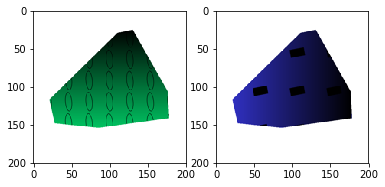

similarity: 0.946


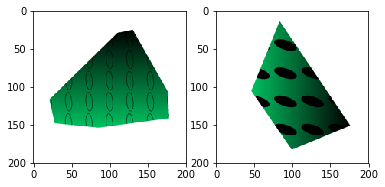

similarity: 0.962


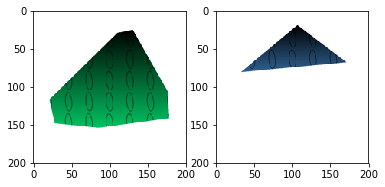




similarity: 0.985


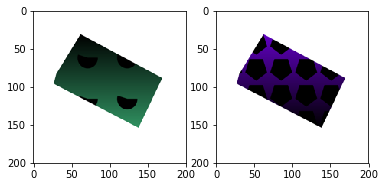

similarity: 0.950


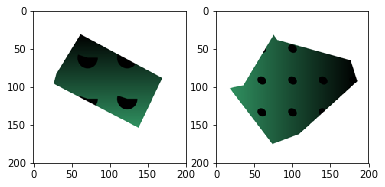

similarity: 0.955


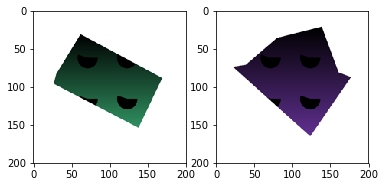




similarity: 0.998


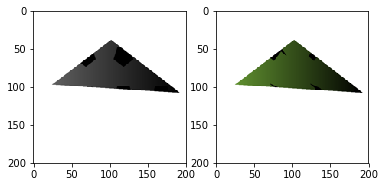

similarity: 0.939


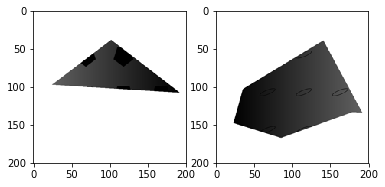

similarity: 0.942


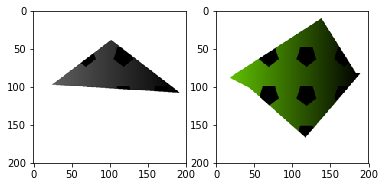

In [61]:
show_img_pairs(model_ca05_ex00, X[:12], -4)

# Now try with artist images

In [4]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder

def load_artist_imgs(save_folder, target_size):
    shapes = []
    colors = []
    textures = []
    imgs = []
    files = [file for file in os.listdir(save_folder) if file.endswith('jpg') or file.endswith('png')]
    for file in files:
        shape, texture, color = file.split('_')
        color = color[:-4]
        shapes.append(shape)
        textures.append(texture)
        colors.append(color)
        img_path = os.path.join(save_folder, file)
        img = image.load_img(img_path, target_size=target_size)
        imgs.append(image.img_to_array(img))
        
    le = LabelEncoder()
    shapes = le.fit_transform(shapes)
    colors = le.fit_transform(colors)
    textures = le.fit_transform(textures)
    
    imgs = np.asarray(imgs)
    imgs /= 255.
    return imgs, shapes, colors, textures

In [5]:
data_folder = '../data/images_artist/'
X_artist, shapes_artist, colors_artist, textures_artist = load_artist_imgs(data_folder, target_size=(200, 200))

In [7]:
X_artist_rgb = X_artist.reshape((len(X_artist), -1))

In [140]:
#X_artist_hidden = get_hidden_representations(model_ca05_ex00, X_artist, layer_num=-4, batch_size=64)

In [6]:
from itertools import combinations

def compute_avg_similarity(X_h, target, other1, other2):
    scores = []
    for cat in set(target):
        print('Collecting scores for category #%i' % cat)
        # Find indices of samples with this category
        inds = list(np.where(target == cat)[0])
        scores_cat = []
        for i, j in combinations(inds, 2):
            assert target[i] == target[j]
            if not (other1[i] == other1[j] or other2[i] == other2[j]):
                scores_cat.append(similarity(X_h[i], X_h[j]))
        print('# scores for this category: %i' % len(scores_cat))
        scores.extend(scores_cat)
    
    return np.mean(scores)

def accuracy_for_layer(X_h, shapes, colors, textures, normalize=True):
    # Loop through the samples and compute accuracy
    print('Computing shape scores...')
    sim_shape = compute_avg_similarity(X_h, target=shapes, other1=colors, other2=textures)
    print('\nComputing color scores...')
    sim_color = compute_avg_similarity(X_h, target=colors, other1=shapes, other2=textures)
    print('\nComputing texture scores...')
    sim_texture = compute_avg_similarity(X_h, target=textures, other1=colors, other2=shapes)
    print('\n')
    
    similarities = [sim_shape, sim_color, sim_texture]
    if normalize:
        similarities /= np.sum(similarities)
    return similarities

In [9]:
# sim_shape_artist, sim_color_artist, sim_texture_artist = accuracy_for_layer(
#     X_artist_hidden, shapes_artist, colors_artist, textures_artist, normalize=False
# )
# print('shape score: %0.3f' % sim_shape_artist)
# print('color score: %0.3f' % sim_color_artist)
# print('texture score: %0.3f' % sim_texture_artist)

In [29]:
def find_match(i, idx, others1, others2):
    idx = np.random.permutation(idx)
    for j in idx:
        if not (others1[i] == others1[j] or others2[i] == others2[j]):
            return j
    print('Failed for ind %i.' % i)
    return -1

def get_group(i, shapes, colors, textures):
    idx_s = list(np.where(shapes == shapes[i])[0])
    idx_c = list(np.where(colors == colors[i])[0])
    idx_t = list(np.where(textures == textures[i])[0])
    idx_s.remove(i)
    idx_c.remove(i)
    idx_t.remove(i)
    i_s = find_match(i, idx_s, colors, textures)
    i_c = find_match(i, idx_c, textures, shapes)
    i_t = find_match(i, idx_t, shapes, colors)
    return [i, i_s, i_c, i_t]
    
def get_groups(shapes, colors, textures):
    groups = []
    for i in range(len(shapes)):
        # 6 is the 'x' texture... ignore those
        if textures[i] == 6:
            continue
        group = get_group(i, shapes, colors, textures)
        if not -1 in group:
            groups.append(group)
    
    return np.asarray(groups)

In [30]:
groups = get_groups(shapes_artist, colors_artist, textures_artist)

In [14]:
def show_imgs(X, X_p, groups):
    
    for group in groups:
        print('\n\n')
        # baseline
        plt.figure(figsize=(3,3))
        plt.imshow(X[group[0]])
        plt.axis('off')
        plt.show()
        # 3 candidates
        fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8,3))
        axes[0].imshow(X[group[1]])
        axes[0].axis('off')
        axes[1].imshow(X[group[2]])
        axes[1].axis('off')
        axes[2].imshow(X[group[3]])
        axes[2].axis('off')
        plt.show()
        print('shape match similarity: %0.3f' % similarity(X_p[group[0]], X_p[group[1]]))
        print('color match similarity: %0.3f' % similarity(X_p[group[0]], X_p[group[2]]))
        print('texture match similarity: %0.3f' % similarity(X_p[group[0]], X_p[group[3]]))

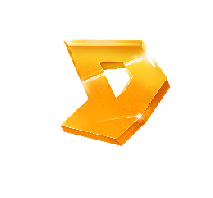

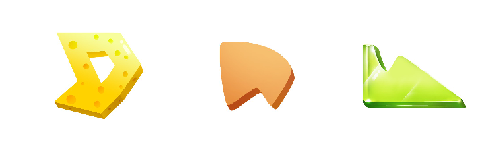

shape match similarity: 0.994
color match similarity: 0.977
texture match similarity: 0.957





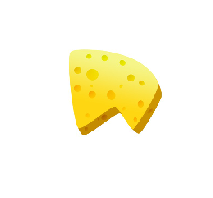

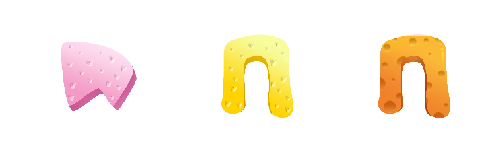

shape match similarity: 0.984
color match similarity: 0.985
texture match similarity: 0.978





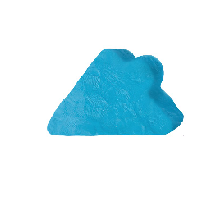

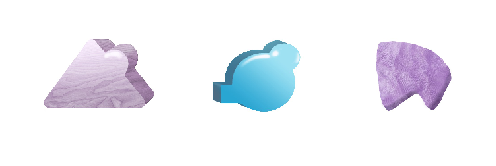

shape match similarity: 0.970
color match similarity: 0.978
texture match similarity: 0.965





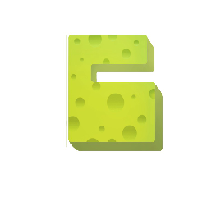

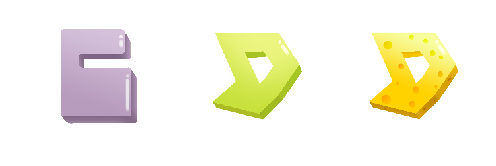

shape match similarity: 0.976
color match similarity: 0.980
texture match similarity: 0.977





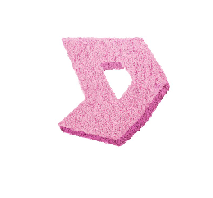

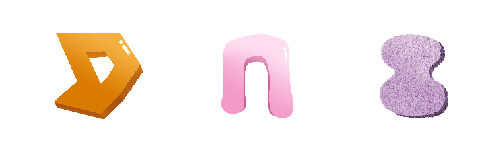

shape match similarity: 0.975
color match similarity: 0.992
texture match similarity: 0.990





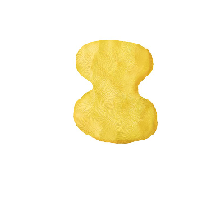

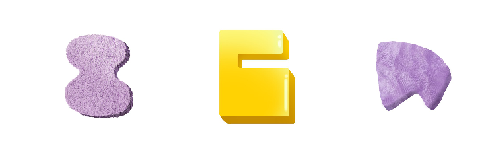

shape match similarity: 0.984
color match similarity: 0.975
texture match similarity: 0.977





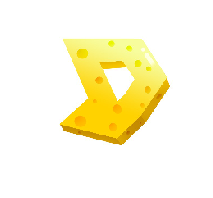

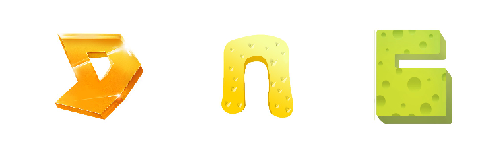

shape match similarity: 0.994
color match similarity: 0.978
texture match similarity: 0.977





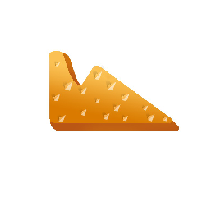

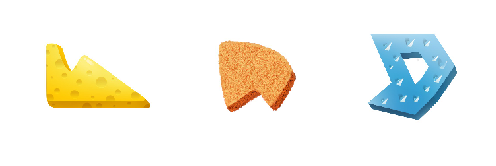

shape match similarity: 0.996
color match similarity: 0.968
texture match similarity: 0.944





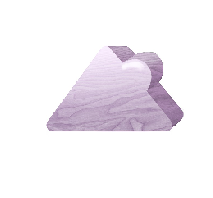

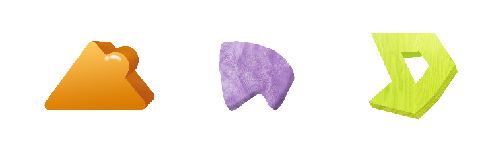

shape match similarity: 0.969
color match similarity: 0.989
texture match similarity: 0.974





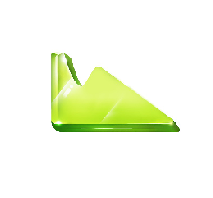

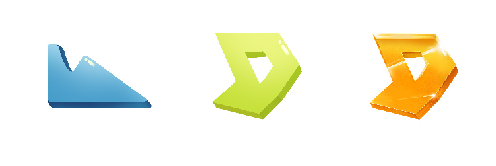

shape match similarity: 0.979
color match similarity: 0.974
texture match similarity: 0.957





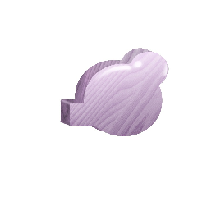

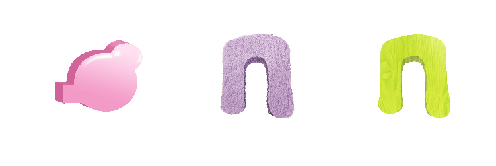

shape match similarity: 0.997
color match similarity: 0.990
texture match similarity: 0.975





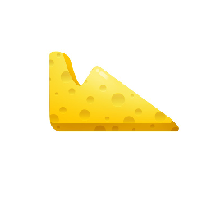

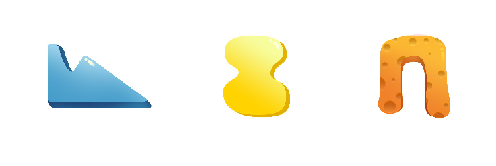

shape match similarity: 0.964
color match similarity: 0.975
texture match similarity: 0.959





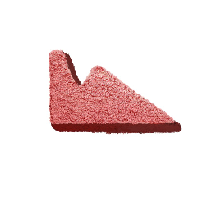

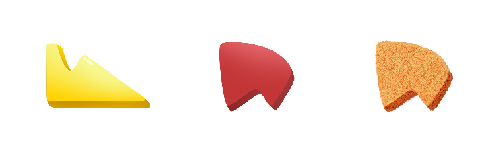

shape match similarity: 0.984
color match similarity: 0.957
texture match similarity: 0.964





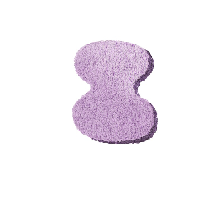

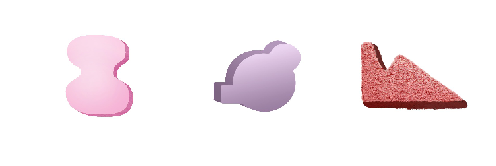

shape match similarity: 0.995
color match similarity: 0.990
texture match similarity: 0.967





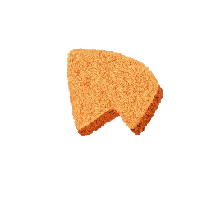

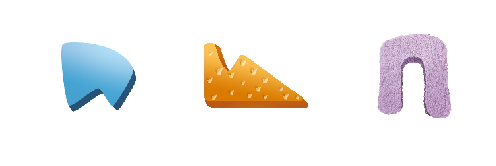

shape match similarity: 0.974
color match similarity: 0.968
texture match similarity: 0.979





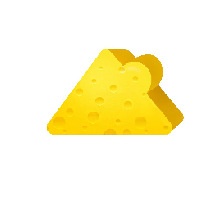

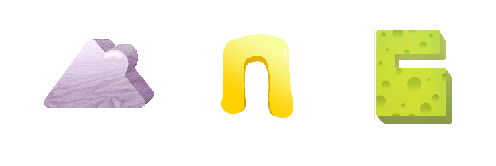

shape match similarity: 0.966
color match similarity: 0.972
texture match similarity: 0.965





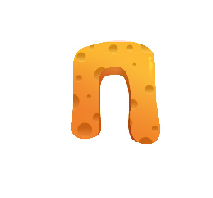

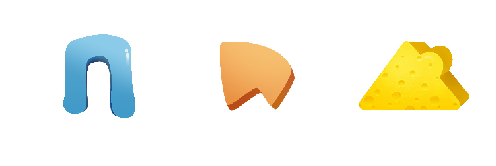

shape match similarity: 0.967
color match similarity: 0.981
texture match similarity: 0.967





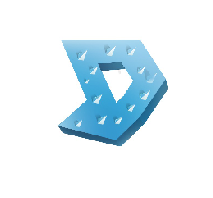

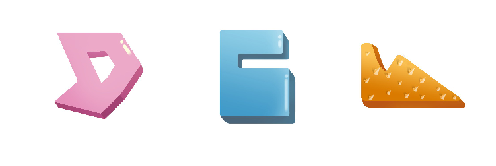

shape match similarity: 0.982
color match similarity: 0.980
texture match similarity: 0.944





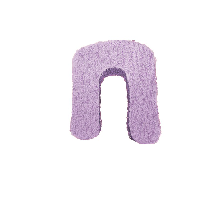

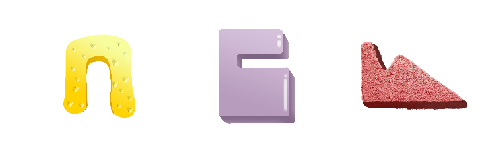

shape match similarity: 0.982
color match similarity: 0.988
texture match similarity: 0.965





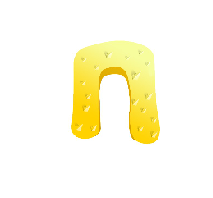

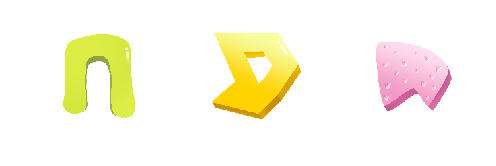

shape match similarity: 0.996
color match similarity: 0.978
texture match similarity: 0.981





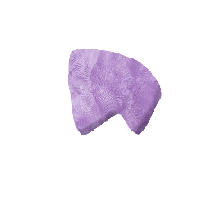

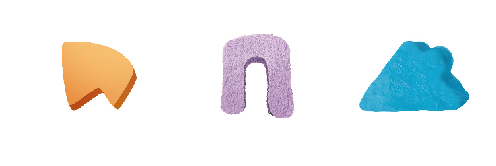

shape match similarity: 0.988
color match similarity: 0.992
texture match similarity: 0.965





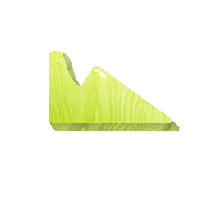

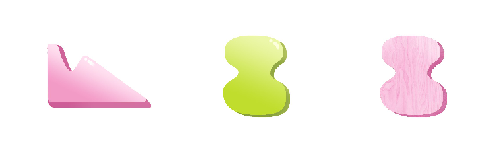

shape match similarity: 0.988
color match similarity: 0.983
texture match similarity: 0.982





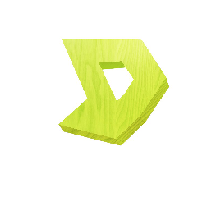

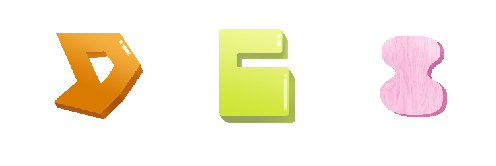

shape match similarity: 0.990
color match similarity: 0.985
texture match similarity: 0.977





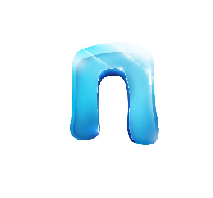

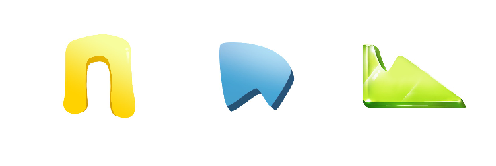

shape match similarity: 0.963
color match similarity: 0.985
texture match similarity: 0.961





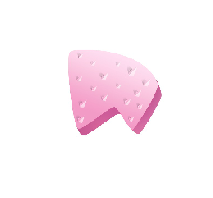

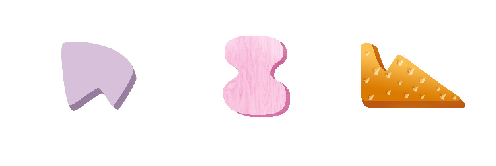

shape match similarity: 0.999
color match similarity: 0.996
texture match similarity: 0.970





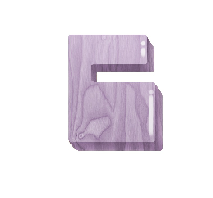

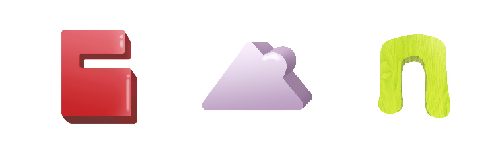

shape match similarity: 0.974
color match similarity: 0.984
texture match similarity: 0.974





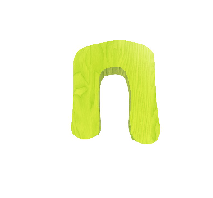

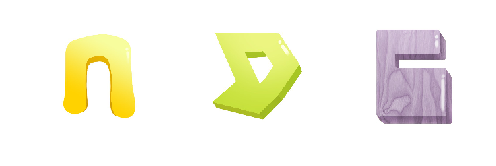

shape match similarity: 0.997
color match similarity: 0.983
texture match similarity: 0.974





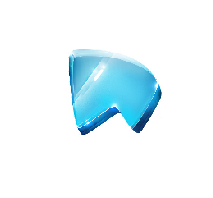

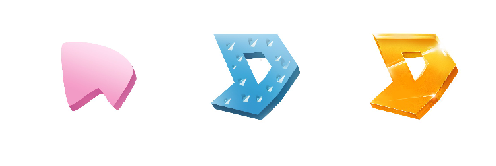

shape match similarity: 0.983
color match similarity: 0.982
texture match similarity: 0.942





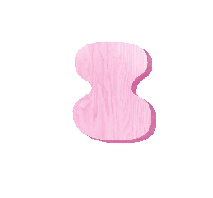

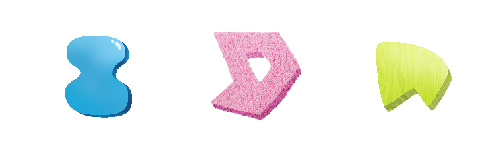

shape match similarity: 0.977
color match similarity: 0.993
texture match similarity: 0.985





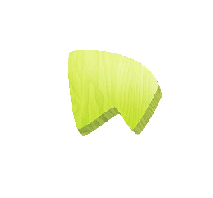

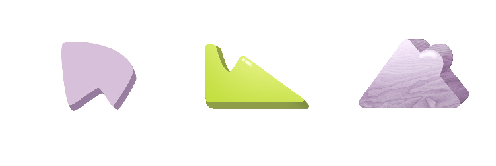

shape match similarity: 0.990
color match similarity: 0.984
texture match similarity: 0.983


In [31]:
show_imgs(X_artist, X_artist_rgb, groups)

In [32]:
def evaluate_secondOrder1(X_p, groups):
    
    nb_correct = 0
    for group in groups:
        score_shape = similarity(X_p[group[0]], X_p[group[1]])
        score_color = similarity(X_p[group[0]], X_p[group[2]])
        score_texture = similarity(X_p[group[0]], X_p[group[3]])
        if score_shape > score_color and score_shape > score_texture:
            nb_correct += 1

    # Return the percentage of times we were correct
    return nb_correct / len(groups)

In [34]:
evaluate_secondOrder1(X_artist_rgb, groups)

0.5333333333333333

In [19]:
def compute_avg_similarity(X_h, target, other1, other2, metric='cosine'):
    scores = []
    for cat in set(target):
        #print('Collecting scores for category #%i' % cat)
        # Find indices of samples with this category
        inds = list(np.where(target == cat)[0])
        scores_cat = []
        for i, j in combinations(inds, 2):
            assert target[i] == target[j]
            if not (other1[i] == other1[j] or other2[i] == other2[j]):
                scores_cat.append(similarity(X_h[i], X_h[j], metric))
        #print('# scores for this category: %i' % len(scores_cat))
        scores.extend(scores_cat)
    
    return np.mean(scores)

In [22]:
shape_avg_score_rgb = compute_avg_similarity(X_artist_rgb, shapes_artist, colors_artist, textures_artist)
color_avg_score_rgb = compute_avg_similarity(X_artist_rgb, colors_artist, textures_artist, shapes_artist)
texture_avg_score_rgb = compute_avg_similarity(X_artist_rgb, textures_artist, shapes_artist, colors_artist)
print('shape avg score: %0.3f' % shape_avg_score_rgb)
print('color avg score: %0.3f' % color_avg_score_rgb)
print('texture avg score: %0.3f' % texture_avg_score_rgb)

shape avg score: 0.981
color avg score: 0.979
texture avg score: 0.967


In [23]:
shape_avg_score_rgb = compute_avg_similarity(X_artist_rgb, shapes_artist, colors_artist, textures_artist, 'euclidean')
color_avg_score_rgb = compute_avg_similarity(X_artist_rgb, colors_artist, textures_artist, shapes_artist, 'euclidean')
texture_avg_score_rgb = compute_avg_similarity(X_artist_rgb, textures_artist, shapes_artist, colors_artist, 'euclidean')
print('shape avg score: %0.3f' % shape_avg_score_rgb)
print('color avg score: %0.3f' % color_avg_score_rgb)
print('texture avg score: %0.3f' % texture_avg_score_rgb)

shape avg score: -59.361
color avg score: -64.201
texture avg score: -82.230


In [189]:
len(groups)

78

## Back to generated images... evaluate 2nd order

In [233]:
def evaluate_secondOrder2(X_p):
    nb_correct = 0
    for i in range(int(len(X) / 4)):
        score_shape = similarity(X_p[4*i], X_p[4*i+1])
        score_color = similarity(X_p[4*i], X_p[4*i+2])
        score_texture = similarity(X_p[4*i], X_p[4*i+3])
        if score_shape > score_color and score_shape > score_texture:
            nb_correct += 1

    # Return the percentage of times we were correct
    return nb_correct / float(len(X)/4)

In [227]:
X.reshape((200,-1)).shape

(200, 120000)

In [234]:
evaluate_secondOrder2(X.reshape((200,-1)))

0.88

## Use Brenden's code to analyze rgb shape bias

In [ ]:
class Stim():

    # class defining a stimulus and its properties
    def __init__(self,fn,img,fvec):
        # input
        #  fn: filename
        #  img: image
        #  fvec: feature vector

        idx = fn.rindex(‘/’)
        tail = fn[idx+1:]
        p = re.compile(‘(\w+)_(\w+)_(\w+).jpg’)
        m = p.match(tail)

        # get properties
        self.filename = fn
        self.name = m.group(1)
        self.material = m.group(2)
        if self.material == ‘x’: self.material = float(‘NaN’)
        self.color = m.group(3)
        if self.color == ‘x’: self.color = float(‘NaN’)
        self.img = img
        self.features = fvec.copy()

def make_trial():
    # create a random triad
    
    while True:
        example = random.choice(stimuli)
        # only matches in color
        poss_color_match = [s for s in stimuli if 
                            (s.color == example.color) & 
                            (s.material != example.material) & 
                            (s.name != example.name)]
        # only matches in material
        poss_material_match = [s for s in stimuli if 
                               (s.material == example.material) & 
                               (s.color != example.color) & 
                               (s.name != example.name)]
        # only matches in shape    
        poss_right_match = [s for s in stimuli if 
                            (s.name == example.name) & 
                            (s.filename != example.filename) & 
                            (s.color != example.color) & 
                            (s.material != example.material)]
            
        if (len(poss_color_match)>0) & (len(poss_material_match)>0) & (len(poss_right_match)>0):
            break # make sure we have an option for each image...

    color = random.choice(poss_color_match)
    material = random.choice(poss_material_match)
    correct = random.choice(poss_right_match)

    return example, correct, color, material